In [1]:
## test experiment class
# using gridworld and actor critic network architecture
import gym
import torch
from Utils import basic_agent_params

import Agents.Networks as nets

from Agents.EpisodicMemory import EpisodicMemory as Memory
from Agents import Agent
from Experiments import Experiment as ex

import numpy as np
import matplotlib.pyplot as plt

import matplotlib.colors as colors
import matplotlib.colorbar as colorbar
import matplotlib.cm as cmx
from Utils import softmax

from scipy.stats import entropy

%matplotlib inline

In [2]:
def get_snapshot(sample_obs, env, agent):
    # get sample observations from all useable spaces in environment
    samples, states = sample_obs

    pols, vals = agent.MFC(torch.Tensor(samples))

    # initialize empty data frames
    pol_grid = np.zeros(env.shape, dtype=[(x, 'f8') for x in env.action_list])
    val_grid = np.empty(env.shape)
    # populate with data from network
    for s, p, v in zip(states, pols, vals):
        pol_grid[s] = tuple(p.data.numpy())
        val_grid[s] = v.item()

    return pol_grid, val_grid

def plot_valmap(maze, value_array, save=False, **kwargs):
    '''
    :param maze: the environment object
    :param value_array: array of state values
    :param save: bool. save figure in current directory
    :return: None
    '''
    show = kwargs.get('show', True)
    directory = kwargs.get('directory', './figures/')
    title = kwargs.get('title', 'State Value Estimates')
    filetype = kwargs.get('filetype', 'svg')
    vals = value_array.copy()
    fig = plt.figure(figsize=(7, 5))
    ax1 = fig.add_axes([0, 0, 0.85, 0.85])
    axc = fig.add_axes([0.75, 0, 0.05, 0.85])
    vmin, vmax = kwargs.get('v_range', [0, 1])
    cmap = plt.cm.Spectral_r
    cNorm = colors.Normalize(vmin=vmin, vmax=vmax)
    for i in maze.obstacles_list:
        vals[i] = np.nan
    cb1 = colorbar.ColorbarBase(axc, cmap=cmap, norm=cNorm)
    ax1.pcolor(vals, cmap=cmap, vmin=vmin, vmax=vmax)

    # add patch for reward location/s (red)
    for rwd_loc in maze.rewards:
        rwd_y, rwd_x = rwd_loc
        ax1.add_patch(plt.Rectangle((rwd_y, rwd_x), width=0.99, height=1, linewidth=1, ec='white', fill=False))

    ax1.set_aspect('equal')
    ax1.invert_yaxis()
    ax1.set_title(title)

    if save:
        plt.savefig(f'{directory}v_{title}.{filetype}', format=f'{filetype}', bbox_inches='tight')
    if show:
        plt.show()

    plt.close()

def plot_polmap(maze, policy_array, save=False, **kwargs):
    '''
    :param maze: the environment object
    :param save: bool. save figure in current directory
    :return: None
    '''
    show = kwargs.get('show', True)
    directory = kwargs.get('directory', './figures/')
    title = kwargs.get('title', 'Most Likely Action from Policy')
    filetype = kwargs.get('filetype', 'svg')
    fig = plt.figure(figsize=(7, 5))
    ax1 = fig.add_axes([0, 0, 0.85, 0.85])
    axc = fig.add_axes([0.75, 0, 0.05, 0.85])

    cmap = plt.cm.Spectral_r
    cNorm = colors.Normalize(vmin=0, vmax=1)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)

    # make base grid
    ax1.pcolor(maze.grid, vmin=0, vmax=1, cmap='bone')
    # add patch for reward location/s (red)
    for rwd_loc in maze.rewards:
        rwd_y, rwd_x = rwd_loc
        ax1.add_patch(plt.Rectangle((rwd_y, rwd_x), width=0.99, height=1, linewidth=1, ec='white', fill=False))

    chance_threshold = kwargs.get('threshold', 0.18)  # np.round(1 / len(maze.actionlist), 6)

    cb1 = colorbar.ColorbarBase(axc, cmap=cmap, norm=cNorm)
    for i in range(maze.c):
        for j in range(maze.r):
            action = np.argmax(tuple(policy_array[i][j]))
            prob = max(policy_array[i][j])

            dx1, dy1, head_w, head_l = make_arrows(action, prob)
            if prob > chance_threshold:
                if (dx1, dy1) == (0, 0):
                    pass
                else:
                    colorVal1 = scalarMap.to_rgba(prob)
                    ax1.arrow(j + 0.5, i + 0.5, dx1, dy1, head_width=0.3, head_length=0.2, color=colorVal1)
            else:
                pass
    ax1.set_aspect('equal')
    ax1.set_title(title)
    ax1.invert_yaxis()

    if save:
        plt.savefig(f'{directory}p_{title}.{filetype}', format=f'{filetype}', bbox_inches='tight')
    if show:
        plt.show()
    plt.close()

def make_arrows(action, probability):
    '''
    alternate style:
        def make_arrows(action):
        offsets = [(0,0.25),(0,-0.25),(0.25,0),(-0.25,0),(0,0),(0.1,0.1) ] # D U R L J P
        dx,dy = offsets[action]
        head_w, head_l = 0.1, 0.1
        return dx, dy, head_w, head_l
    :param action:
    :param probability:
    :return:
    '''
    if probability == 0:
        dx, dy = 0, 0
        head_w, head_l = 0, 0
    else:
        dxdy = [(0.0, 0.25),  # D
                (0.0, -0.25),  # U
                (0.25, 0.0),  # R
                (-0.25, 0.0),  # L
                (0.1, -0.1),  # points right and up #J
                (-0.1, 0.1),  # points left and down # P
                ]
        dx, dy = dxdy[action]  #dxdy[(action-1)%len(dxdy)] ## use if action-space remapping

        head_w, head_l = 0.1, 0.1

    return dx, dy, head_w, head_l

def plot_softmax(x, T=1):
    f, axarr = plt.subplots(2, sharex=True)
    axarr[0].bar(np.arange(len(x)), x)
    y = softmax(x, T)
    axarr[1].bar(np.arange(len(x)), y)
    plt.show()

def opt_pol_map(env):
    optimal_policy = np.zeros((env.y, env.x, len(env.actionlist)))
    for location in env.useable:
        xdim, ydim = location
        xrwd, yrwd = env.rwd_loc[0]

        if xdim < xrwd:
            optimal_policy[ydim, xdim][1] = 1
            if ydim < yrwd:
                optimal_policy[ydim, xdim][3] = 1
            elif ydim > yrwd:
                optimal_policy[ydim, xdim][0] = 1

        elif xdim > xrwd:
            optimal_policy[ydim, xdim][2] = 1
            if ydim < yrwd:
                optimal_policy[ydim, xdim][3] = 1
            elif ydim > yrwd:
                optimal_policy[ydim, xdim][0] = 1
        else:
            if ydim < yrwd:
                optimal_policy[ydim, xdim][3] = 1
            elif ydim > yrwd:
                optimal_policy[ydim, xdim][0] = 1
            else:
                optimal_policy[ydim, xdim][5] = 1

        optimal_policy[ydim, xdim] = softmax(optimal_policy[ydim, xdim], T=0.01)

    return optimal_policy


######################
def plot_pref_pol(maze, policy_array, save=False, **kwargs):
    '''
        :param maze: the environment object
        :param save: bool. save figure in current directory
        :return: None
        '''
    show = kwargs.get('show', True)
    title = kwargs.get('title', 'Policy Entropy')
    directory = kwargs.get('directory', './figures/')
    filetype = kwargs.get('filetype', 'svg')
    vmax = kwargs.get('upperbound', 2)
    rewards = kwargs.get('rwds', maze.rewards)
    fig = plt.figure(figsize=(7, 5))
    ax1 = fig.add_axes([0, 0, 0.85, 0.85])
    axc = fig.add_axes([0.75, 0, 0.05, 0.85])

    cmap = plt.cm.Spectral_r
    cNorm = colors.Normalize(vmin=0, vmax=vmax)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
    cb1 = colorbar.ColorbarBase(axc, cmap=cmap, norm=cNorm)
    # make base grid
    ax1.pcolor(maze.grid, vmin=0, vmax=vmax, cmap='bone')
    # add patch for reward location/s (red)
    for rwd_loc in rewards:
        rwd_r, rwd_c = rwd_loc
        ax1.add_patch(plt.Rectangle((rwd_c, rwd_r), width=0.99, height=1, linewidth=1, ec='white', fill=False))

    chance_threshold = kwargs.get('threshold', 0.18)  # np.round(1 / len(maze.actionlist), 6)

    for i in range(maze.r):
        for j in range(maze.c):
            policy = tuple(policy_array[i, j])

            dx, dy = 0.0, 0.0
            for ind, k in enumerate(policy):
                action = ind
                prob = k
                if prob < 0.01:
                    pass
                else:
                    dx1, dy1, head_w, head_l = make_arrows(action, prob)
                    dx += dx1*prob
                    dy += dy1*prob
            if dx ==0.0 and dy == 0.0:
                pass
            else:
                colorVal1 = scalarMap.to_rgba(entropy(policy))
                if entropy(policy) > 1.2:
                    pass
                else:
                    ax1.arrow(j + 0.5, i + 0.5, dx, dy, head_width=0.3, head_length=0.5, color=colorVal1)


    ax1.set_aspect('equal')
    ax1.set_title(title)
    ax1.invert_yaxis()

    if save:
        plt.savefig(f'{directory}pref_{title}.{filetype}', format=f'{filetype}', bbox_inches='tight')
    if show:
        plt.show()
    plt.close()


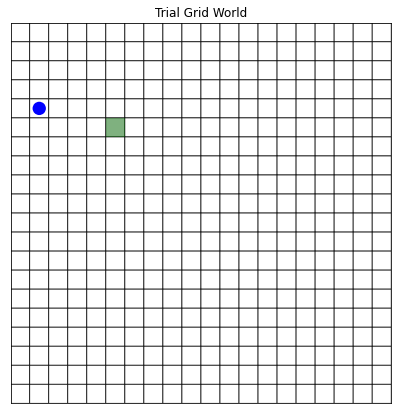

In [3]:
# Make Environment to Test Agent in
env = gym.make('gym_grid:gridworld-v1')

params = basic_agent_params(env)
network = nets.ActorCritic(params)
memory = Memory(entry_size=params.action_dims, cache_limit=1000, mem_temp=0.1)
memory.similarity_measure = memory.key_sim
agent = Agent(network, memory=memory)
agent.get_action = agent.EC_action

sample_observations = env.get_sample_obs()

run = ex(agent,env)

In [5]:
run.run(100,100, printfreq=50, render=False)

/home/annik/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Episode: 0, Score: -1.0000000000000007 (Running Avg:-1.0000000000000007) [0.5562572479248047s]
Episode: 50, Score: 9.94 (Running Avg:3.8040346907993974) [34.45109844207764s]


Episode: 0, Score: 9.76 (Running Avg:9.76) [0.41300272941589355s]
Episode: 50, Score: 9.85 (Running Avg:4.912903469079938) [14.428937673568726s]


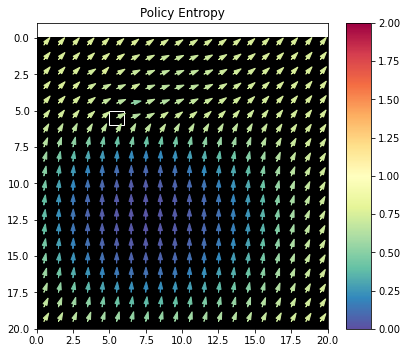

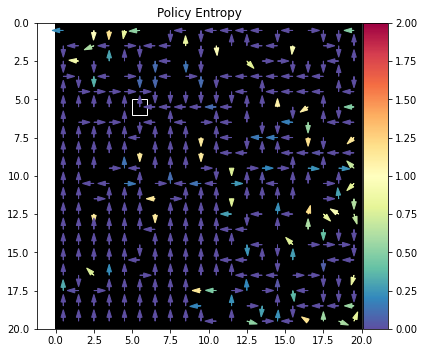

Episode: 0, Score: 9.88 (Running Avg:9.88) [0.26941847801208496s]
Episode: 50, Score: 9.91 (Running Avg:4.933589743589745) [18.78660774230957s]


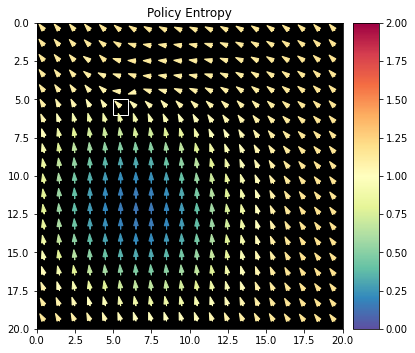

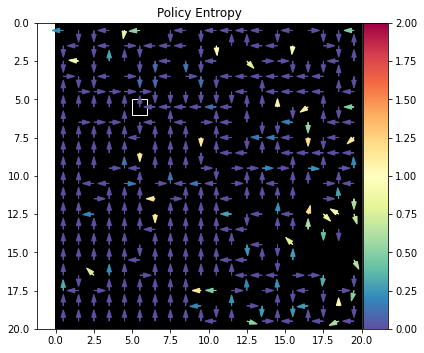

Episode: 0, Score: 9.92 (Running Avg:9.92) [0.16644883155822754s]
Episode: 50, Score: 9.83 (Running Avg:4.922006033182504) [18.147403955459595s]


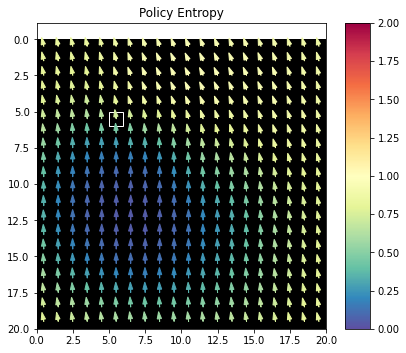

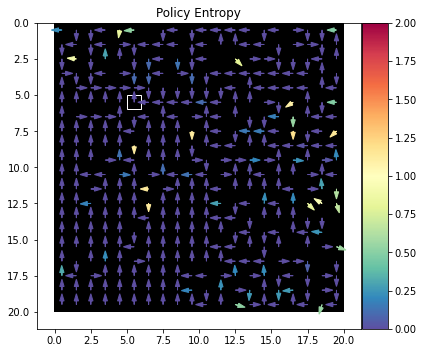

Episode: 0, Score: 9.8 (Running Avg:9.8) [0.39923524856567383s]
Episode: 50, Score: 9.83 (Running Avg:4.923487933634991) [18.519093990325928s]


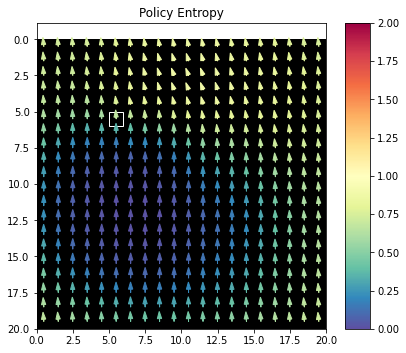

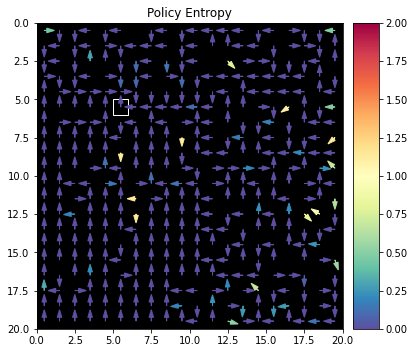

Episode: 0, Score: 9.92 (Running Avg:9.92) [0.19747424125671387s]
Episode: 50, Score: 9.81 (Running Avg:4.784276018099549) [19.88273811340332s]


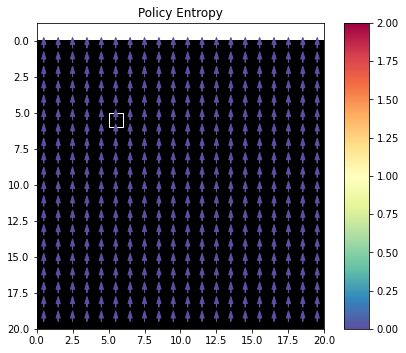

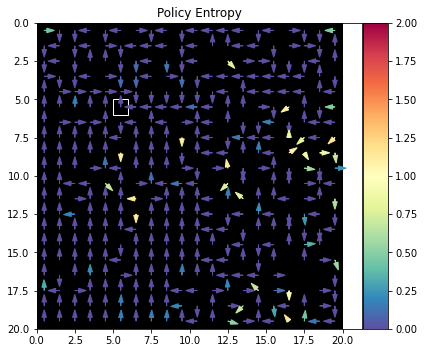

Episode: 0, Score: 9.92 (Running Avg:9.92) [0.1759047508239746s]
Episode: 50, Score: 9.92 (Running Avg:4.826813725490196) [18.883599758148193s]


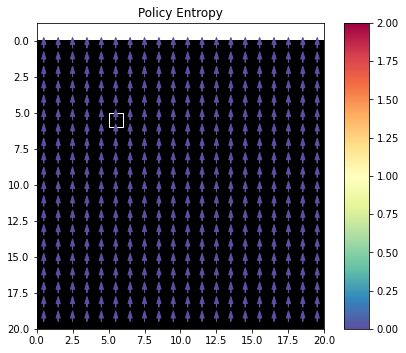

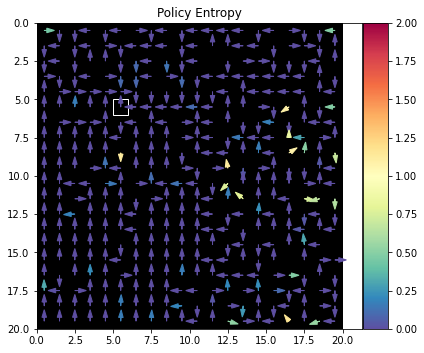

Episode: 0, Score: 9.97 (Running Avg:9.97) [0.09252095222473145s]
Episode: 50, Score: 9.7 (Running Avg:4.815565610859729) [24.043391704559326s]


KeyboardInterrupt: 

In [9]:
for x in range(10):
    run.run(100,100, printfreq=50, render=False)
    pol_grid, val_grid = get_snapshot(sample_observations, env, agent)
    plot_pref_pol(env,pol_grid)
    
    mem_grid = np.zeros(env.shape, dtype=[(x, 'f8') for x in env.action_list])

    for state in range(env.nstates):
        state_rep = np.zeros(env.nstates)
        state_rep[state] = 1
        state_rep = tuple(state_rep)

        state_coord = env.oneD2twoD(state)

        recallify = agent.EC.recall_mem(state_rep)
        mem_grid[state_coord[0], state_coord[1]] = tuple(recallify)
    plot_pref_pol(env, mem_grid)

In [10]:
s = (0,0)
s1d = env.twoD2oneD(s)
obs = np.expand_dims(env.get_observation(agtlocation=s), axis=0)

policy, value = agent.MFC(obs)
print(policy)

tensor([[5.0524e-17, 1.0000e+00, 3.8445e-16, 6.7618e-15]],
       grad_fn=<SoftmaxBackward>)


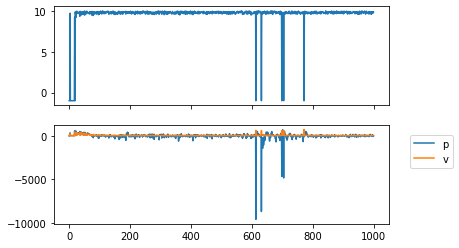

In [21]:
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(run.data['total_reward'])
ax[1].plot(run.data['loss'][0], label='p')
ax[1].plot(run.data['loss'][1], label='v')
ax[1].legend(bbox_to_anchor=(1.05, 0.95))
plt.show()

In [ ]:
agent.EC.mem_temp

In [7]:
import numpy as np
pol_grid, val_grid = get_snapshot(sample_observations, env, agent)

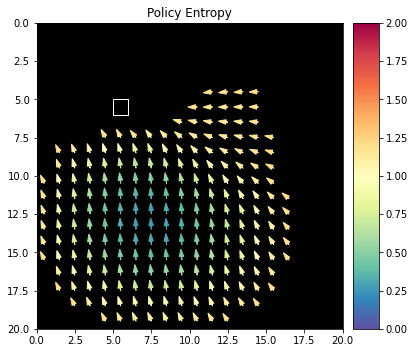

In [8]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.colorbar as colorbar
import matplotlib.cm as cmx
from Utils import softmax

from scipy.stats import entropy

plot_pref_pol(env,pol_grid)

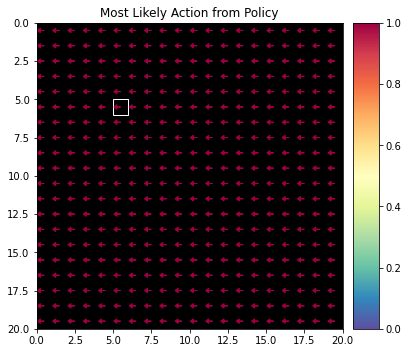

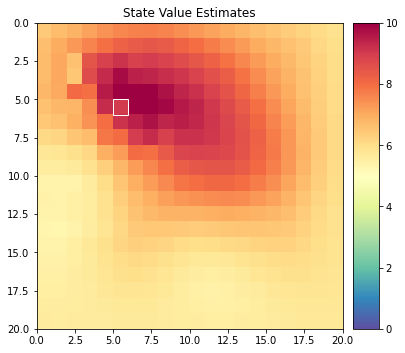

In [23]:
plot_polmap(env, pol_grid)
plot_valmap(env, val_grid, v_range=[0,10])